# Enviromental Sound Classification and Quantization Effect

This project aims to construct a CNN model for environmental sound classification problem. Then, investigate the quantization effect on the constructed model. All neccessary details are given under the related subtitle.

Important Notice: UrbanSound8k Dataset should be downloaded before executing the notebook. The Dataset should be under the "audio" folder that is in the same folder with this notebook. Also, the metadata excell that contains the dataset information should be ready in the file called "metadata". Both of them can be downloaded from the same link. 
Download link of dataset: https://urbansounddataset.weebly.com/urbansound8k.html

Example file structre : source -> Notebook.ipynb, audio, metadata . metadata -> UrbanSound8K.csv . audio -> fold1, fold2 ...

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display

import pickle
from scipy.io import wavfile as wav
import math

import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.quantization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from decimal import *
import matplotlib.pyplot as plt
%matplotlib inline


UrbanSound8K is a public audio dataset that contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music.

In [2]:
# Get Metadata of the Dataset, it contains labels of the auido files in the dataset
meta_data = pd.read_csv("metadata/UrbanSound8K.csv")  

# Display shape and head of the dataset
print(np.shape(meta_data)) # (8732, 8)
print(meta_data.head())

# Get list of the classes of the dataset from the metada file
classes = list(meta_data['class'].unique()) 

(8732, 8)
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


# Feature Extraction : MFCC
128 MFCC coefficient is extracted from the each audio in the dataset. LibRosa library is used for MFCC extraction. 

In [3]:
# Feature extraction function for mfcc , librosa library is used
# Default number of mfcc coefficients is determined as 128
def feature_extractor_mfcc(file_name,scale=True,padding=False,max_pad=None,n=128):
    '''
    Function to extract features from the audio file
    Does the following things using Librosa library:
        - Converts the sampling rate to 22.05 KHz
        - Normalize the Bit-depth values of the audio
        - Merge the audio channels into a Mono (single) channel
    Parameters: 
    Input:
        file_name : string; 
                    Path of the file to be processed 
        scale : False; 
                True when 1D features are required calculated 
                by taking mean along the axis
        padding : False; 
                  True when 2D features are required with padding
        max_pad : None [int]; 
                  Maxium size of a padded image/array. 
                  Required when padding is set to True
        n = 40 [int]; 
            Number of MFCCs to return          
    Output:
        mfccs = array of mfccs features.
                (1D when scaling = True
                 2D when padding = True)   
    '''
    try:        
        audio, sample_rate = librosa.load(file_name, 
                                          res_type='kaiser_fast') 
        
        mfccs = librosa.feature.mfcc(y = audio, 
                                     sr = sample_rate, 
                                     n_mfcc = n) 
            
        if padding:
            pad_width = max_pad - mfccs.shape[1]
            mfccs = np.pad(mfccs, 
                           pad_width=((0, 0), (0, pad_width)), 
                           mode='constant')
            
        if scale: 
            mfccs = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [4]:
# Function to extract features from dataset and save it in the .pkl format (contains pandas.DataFrame)
# Basically, it reads audio files in "auido" folder by checking from metadata excell
def extract_mfcc():
    feat_list_mfcc = []
    for index, row in meta_data.iterrows():

        file_name = os.path.join(os.path.abspath('audio/'),
                                 'fold'+str(row["fold"])+'/',
                                 str(row["slice_file_name"]))
        class_label = row["class"]
        data_mfcc = feature_extractor_mfcc(file_name,scale=True)
        feat_list_mfcc.append([data_mfcc, class_label])

    features_mfcc = pd.DataFrame(feat_list_mfcc, columns=['feature','class_label'])

    print('Processed ', len(features_mfcc), ' files')
    print('Output Feature shape ',np.shape(features_mfcc.iloc[0,0]))
    features_mfcc.to_pickle("./mfcc_128_features.pk1")

In [5]:
#Call feature extractors
extract_mfcc()
print("128 MFCC features extraction DONE")

C:\Users\HAKAN\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
C:\Users\HAKAN\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
C:\Users\HAKAN\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


Processed  8732  files
Output Feature shape  (128,)
128 MFCC features extraction DONE


# Create Dataset from extracted MFCC features

In [6]:
# Read fetures from saved point
features_1D_mfcc_128 = pd.read_pickle("./mfcc_128_features.pk1")
# Convert pandas DataFrame to numpy arrays
X_1D_mfcc_128 = np.array(features_1D_mfcc_128.feature.tolist())
y_1D_mfcc_128_ = np.array(features_1D_mfcc_128.class_label.tolist())

In [7]:
# LabelEncoder is for Encode target labels with value between 0 and n_classes-1.
label_encoders = LabelEncoder()
y_1D_mfcc_128 = to_categorical(label_encoders.fit_transform(y_1D_mfcc_128_))

In [8]:
# Split datasaet to training and testing
x_train, x_test, y_train, y_test = train_test_split(X_1D_mfcc_128,y_1D_mfcc_128,test_size=0.2,random_state = 42)

In [9]:
# Convert numpy arrays to tensors 
torch_x_train_ = torch.Tensor(x_train)
torch_x_test_ = torch.Tensor(x_test)
torch_y_train = torch.Tensor(y_train)
torch_y_test = torch.Tensor(y_test)

In [10]:
# Size correction for further methods
torch_x_train = torch.unsqueeze(torch_x_train_,1)
torch_x_test = torch.unsqueeze(torch_x_test_,1)

In [11]:
# Create dataset and dataloader
dataset_train = TensorDataset(torch_x_train,torch_y_train) 
dataloader_train = DataLoader(dataset_train) 

dataset_test = TensorDataset(torch_x_test,torch_y_test) 
dataloader_test = DataLoader(dataset_test) 

# Define Network Models
Convolutional Neural Network is defined. It is consistent with the paper [1]. The paper uses 2D convolution, and construct 1D MFCC features as 2D image. It is found unnecessary. Therefore, 1D convolution is used in this project. Layer types and numbers are consistent with the paper. 

[1] K. J. Piczak, "Environmental sound classification with convolutional neural networks,"
2015 IEEE 25th International Workshop on Machine Learning for Signal Processing (MLSP),
2015, pp. 1-6, doi: 10.1109/MLSP.2015.7324337.

In [12]:
class ConvNetQuant(torch.nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=24, kernel_size=5, padding=0)
        self.conv2 = nn.Conv1d(in_channels=24, out_channels=36, kernel_size=4, padding=0)
        self.conv3 = nn.Conv1d(in_channels=36, out_channels=48, kernel_size=3, padding=0)

        self.lin1 = nn.Linear(in_features=48, out_features=60)
        
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
        self.classifier = torch.nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=60, out_features=10),
        )
        
        self.relu0 = torch.nn.ReLU()
        self.relu1 = torch.nn.ReLU()
        self.relu2 = torch.nn.ReLU()
        self.relu3 = torch.nn.ReLU()      
        
    def forward(self, x):
        # Pointing where the quantization starts with quant()
        x = self.quant(x)
        
        # cnn layer-1
        x = self.conv1(x)
        x = F.max_pool1d(x, kernel_size=3, stride=3)
        x = self.relu0(x)

        # cnn layer-2
        x = self.conv2(x)
        x = F.max_pool1d(x, kernel_size=2, stride=2)
        x = self.relu1(x)

        # cnn layer-3
        x = self.conv3(x)
        x = self.relu2(x)

        # global average pooling 1D
        x = F.avg_pool1d(x, kernel_size=x.size()[2:])
        x = x.view(-1, 48)

        # dense layer-1
        x = self.lin1(x)
        x = self.relu3(x)

        # dense output layer
        x = self.classifier(x)
        x = self.dequant(x)

        return x
    
convnet = ConvNetQuant()

In [13]:
# Test the nn model to see it generates output for 10 classes in the dataset
test_convnet = ConvNetQuant()
test_input = torch.randn(1,1,128)
test_output = test_convnet(test_input)
print(test_output.shape)

torch.Size([1, 10])


In [14]:
# Optimizer and loss function. They are good choices for a cnn networks
optimizer = optim.Adam(convnet.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Training & Accuracy Check

In [15]:
def check_accuracy(neuralnet, dataloader, timer = False):
    correct_ = 0 
    total_ = 0
    elapsed = 0
    num_counted = 0
    # Accuracy check should be in evaluation mode
    neuralnet.eval()
    with torch.no_grad():
        
        for data in dataloader:
            audio, labels = data
            # Timer is to check the inference time of the model
            if timer:
                start = time.time()
                outputs_ = neuralnet(audio)
                end = time.time()
                elapsed = elapsed + (end-start)
                num_counted += 1
            else:
                outputs_ = neuralnet(audio)
            # Reshaping for further process
            outputs = outputs_.squeeze()
            labels = labels.squeeze()
            
            size_ = outputs.size()
            output_result = torch.argmax(outputs)
            label_result = torch.argmax(labels)
            # Check results
            for x in range(size_[0]):
                total_ += 1
                if (torch.eq(output_result,label_result)):
                    correct_ += 1
    # 
    if timer:
        print('Total elapsed-inference time: ', elapsed)
        print('Total number of input passed for inference: ', num_counted)

    accuracy = correct_ / total_

    return accuracy 

In [16]:
# Since PyTorch accumulates the gradients on subsequent backward passes, we should make zero the gradient for every mini-batch.
# Then, give input to nn model and get output. Calculate loss with comparing output and labels by using loss function.
# Then, we should compute gradient parameters by backward propagation of loss
# Then, we should update paramets based on current gradient. 
def train_one_epoch(neuralnet, dataloader, optimizer_, loss_fn_):
    # The model should be in train mode
    neuralnet.train()
    for data_batch, labels_batch in dataloader:
        
        optimizer_.zero_grad()
        outputs = neuralnet(data_batch)
        loss = loss_fn_(outputs, labels_batch)
        loss.backward()
        optimizer_.step()

In [17]:
# Training the network
training_accuracy_list = []
validation_accuracy_list = []
def train(network, num_epoch = 25):
    network.train()
    for epoch_no in range(num_epoch):
        print(f'Epoch {epoch_no + 1}...')

        train_one_epoch(network, dataloader_train, optimizer, loss_fn)

        training_accuracy = check_accuracy(network, dataloader_train)
        print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
        validation_accuracy = check_accuracy(network, dataloader_test)
        print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')

        training_accuracy_list.append(training_accuracy)
        validation_accuracy_list.append(validation_accuracy)  
train(convnet)
# Save the trained model parameters
torch.save(convnet.state_dict(),"./model_save")

Epoch 1...
Training   accuracy: 48.02%
Validation accuracy: 49.00%
Epoch 2...
Training   accuracy: 57.42%
Validation accuracy: 57.07%
Epoch 3...
Training   accuracy: 60.62%
Validation accuracy: 61.48%
Epoch 4...
Training   accuracy: 66.07%
Validation accuracy: 65.71%
Epoch 5...
Training   accuracy: 69.19%
Validation accuracy: 67.49%
Epoch 6...
Training   accuracy: 70.91%
Validation accuracy: 69.83%
Epoch 7...
Training   accuracy: 72.94%
Validation accuracy: 71.84%
Epoch 8...
Training   accuracy: 76.23%
Validation accuracy: 74.64%
Epoch 9...
Training   accuracy: 76.71%
Validation accuracy: 75.39%
Epoch 10...
Training   accuracy: 75.88%
Validation accuracy: 75.84%
Epoch 11...
Training   accuracy: 78.45%
Validation accuracy: 76.42%
Epoch 12...
Training   accuracy: 77.65%
Validation accuracy: 76.59%
Epoch 13...
Training   accuracy: 81.06%
Validation accuracy: 78.59%
Epoch 14...
Training   accuracy: 76.74%
Validation accuracy: 75.44%
Epoch 15...
Training   accuracy: 81.07%
Validation accura

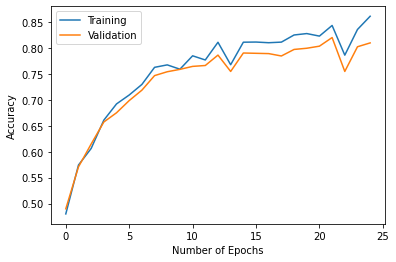

In [18]:
# Plot the Accuracy of training and validation
plt.plot(training_accuracy_list, label = "Training")
plt.plot(validation_accuracy_list, label = "Validation")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Quantization
Three types of quantization are used. They are static post training quantization, dynamic post training quantization, and quantization aware training. Pytorch library is used for quantization.

In [19]:
# Load saved model parameters for non-quantized model eveluation
loaded_model_nq = ConvNetQuant()
loaded_model_nq.load_state_dict(torch.load("./model_save"))
loaded_model_nq.eval()

# Load saved model parameters for Static Post Training Quantization 
loaded_model_pqs = ConvNetQuant()
loaded_model_pqs.load_state_dict(torch.load("./model_save"))
loaded_model_pqs.eval()

# Load saved model parameters for Dynamic Post Training Quantization 
loaded_model_pqd = ConvNetQuant()
loaded_model_pqd.load_state_dict(torch.load("./model_save"))
loaded_model_pqd.eval()

# Load saved model parameters for Quantization Aware Training
loaded_model_qat = ConvNetQuant()
loaded_model_qat.load_state_dict(torch.load("./model_save"))
loaded_model_qat.eval()

ConvNetQuant(
  (conv1): Conv1d(1, 24, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(24, 36, kernel_size=(4,), stride=(1,))
  (conv3): Conv1d(36, 48, kernel_size=(3,), stride=(1,))
  (lin1): Linear(in_features=48, out_features=60, bias=True)
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=60, out_features=10, bias=True)
  )
  (relu0): ReLU()
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
)

## Post Quantization - Static (PQS)
Static quantization quantizes the weights and activations of the model. It fuses activations into preceding layers where possible. It requires calibration with a representative dataset to determine optimal quantization parameters for activations.

Warning: Pytorch quantization implementation is in Beta version. Therefore, it gives some warnings. Searching the warning on pytorch website shows that it is normal and should not be concern.

In [20]:
# 'fbgemm' is suitable for the most of the personal computers with x86 architecture. 
# Since quantization is dependent on the hardware, it is important to choose correct qconfig.
loaded_model_pqs.qconfig = torch.quantization.get_default_qconfig('fbgemm')
print(loaded_model_pqs.qconfig)

# Fuse the activations to preceding layers, where applicable.
laoded_model_fused_pqs = torch.quantization.fuse_modules(loaded_model_pqs, [['conv3', 'relu2'], ['lin1', 'relu3']])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
loaded_model_prepared_pqs = torch.quantization.prepare(laoded_model_fused_pqs)

# calibrate the prepared model to determine quantization parameters for activations
check_accuracy(loaded_model_prepared_pqs, dataloader_test)

print('Post Training Quantization - Static: Calibration done')

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
quantized_model_pqs = torch.quantization.convert(loaded_model_prepared_pqs)
print('Post Training Quantization - Static: Convert done')

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


C:\Users\HAKAN\anaconda3\lib\site-packages\torch\ao\quantization\observer.py:172: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Post Training Quantization - Static: Calibration done
Post Training Quantization - Static: Convert done


C:\Users\HAKAN\anaconda3\lib\site-packages\torch\ao\quantization\observer.py:886: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_begin // dst_bin_width, 0, self.dst_nbins - 1
C:\Users\HAKAN\anaconda3\lib\site-packages\torch\ao\quantization\observer.py:891: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_end // dst_bin_wid

## Post Quantization - Dynamic
Weights are quantized ahead of time but the activations are dynamically quantized during inference. 

In [21]:
quantized_model_pqd = torch.quantization.quantize_dynamic(
    loaded_model_pqd,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

# calibrate the prepared model to determine quantization parameters for activations
check_accuracy(quantized_model_pqd, dataloader_test)
print('Post Training Quantization - Dynamic: Calibration done')
# Since we created quantized model instance, no need for conversion 

Post Training Quantization - Dynamic: Calibration done


## Quantization Aware Training

Quantization Aware Training models the effects of quantization during training allowing for higher accuracy compared to other quantization methods. During training, all calculations are done in floating point, with fake_quant modules modeling the effects of quantization by clamping and rounding to simulate the effects of INT8. After model conversion, weights and activations are quantized, and activations are fused into the preceding layer where possible.

In [22]:
# 'fbgemm' is suitable for the most of the personal computers with x86 architecture. 
# Since quantization is dependent on the hardware, it is important to choose correct qconfig.
loaded_model_qat.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
print(loaded_model_qat.qconfig)

# Fuse the activations to preceding layers, where applicable.
laoded_model_fused_qat = torch.quantization.fuse_modules(loaded_model_qat, [['conv3', 'relu2'], ['lin1', 'relu3']])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
loaded_model_prepared_qat = torch.quantization.prepare_qat(laoded_model_fused_qat)

# run the training loop for fine tuning which is the main logic of quantization aware training
# Accuracy of this training is lower than actaul performance 
# becouse it tunes the parameters for quantization, but quantize the model after this training
loaded_model_prepared_qat.train()
train(loaded_model_prepared_qat, num_epoch = 1)
print('Quantization Aware Training: Calibration done')

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
loaded_model_prepared_qat.eval()
quantized_model_qat = torch.quantization.convert(loaded_model_prepared_qat)
print('Post Training Quantization: Convert done')

QConfig(activation=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, quant_min=0, quant_max=255, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Epoch 1...
Training   accuracy: 69.59%
Validation accuracy: 69.49%
Quantization Aware Training: Calibration done
Post Training Quantization: Convert done


# Benchmarking Quantization Types
There are 3 main parameters for comparision.

Accuracy: It is expected that quantization will decrease the accuracy. Dynamic post training quantization quantizae only one linear layer, so accuracy did not decrease at all. Static post training quantization decreases the accuracy. QAT makes fine tuning over the static post training quantization, so accuracy is closer to the non-quantized model. 

Inference time: It is expected that quantization will make inference faster. However, it did not happen in this project. Pytorch claims that different results can be observed with different hardwares. Also, the pytorch quantization is in beta version. 

Model size: It is expected that quantization will compress the model size. It is observed. Model size is decreased to half in QAT and static post training quantization. Since only one layer is quantized in dynamic post training quantization, decrease in model size is small. 

In [23]:
    print('Time elapsed in non-quantized model:')
    acc_nq = check_accuracy(loaded_model_nq, dataloader_test, timer = True) #loaded_model_nq
    print(f'Validation accuracy of non-quantized model: {acc_nq * 100 :.2f}%')
    print('---------------')
    
    print('Time elapsed in static post training quantization model:')
    acc_pqs = check_accuracy(quantized_model_pqs, dataloader_test, timer = True) # quantized_model_pqd
    print(f'Validation accuracy of static post training quantization model: {acc_pqs * 100 :.2f}%')
    print('---------------')
    
    print('Time elapsed in dynamic post training quantization model:')
    acc_pqd = check_accuracy(quantized_model_pqd, dataloader_test, timer = True) # quantized_model_pqd
    print(f'Validation accuracy of dynamic post training quantization model: {acc_pqd * 100 :.2f}%')
    print('---------------')
    
    print('Time elapsed in quantization aware training model:')
    acc_qat = check_accuracy(quantized_model_qat, dataloader_test, timer = True) #quantized_model_qat
    print(f'Validation accuracy of quantization aware training model: {acc_qat * 100 :.2f}%')

Time elapsed in non-quantized model:
Total elapsed-inference time:  0.6033754348754883
Total number of input passed for inference:  1747
Validation accuracy of non-quantized model: 80.94%
---------------
Time elapsed in static post training quantization model:
Total elapsed-inference time:  5.50814962387085
Total number of input passed for inference:  1747
Validation accuracy of static post training quantization model: 61.48%
---------------
Time elapsed in dynamic post training quantization model:
Total elapsed-inference time:  2.4956748485565186
Total number of input passed for inference:  1747
Validation accuracy of dynamic post training quantization model: 80.88%
---------------
Time elapsed in quantization aware training model:
Total elapsed-inference time:  5.237109661102295
Total number of input passed for inference:  1747
Validation accuracy of quantization aware training model: 72.52%


In [24]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [25]:
## Size of the model is an important parameter to evaluate quantization effect
print("Size of non-quantized model:")
print_size_of_model(loaded_model_nq)
print("Size of static post training quantization model:")
print_size_of_model(quantized_model_pqs)
print("Size of dynamic post training quantization model:")
print_size_of_model(quantized_model_pqd)
print("Size of quantization aware training model:")
print_size_of_model(quantized_model_qat)

Size of non-quantized model:
Size (MB): 0.052679
Size of static post training quantization model:
Size (MB): 0.024837
Size of dynamic post training quantization model:
Size (MB): 0.043579
Size of quantization aware training model:
Size (MB): 0.024837
